In [ ]:
!pip install pyyaml==5.4.1

In [ ]:
!pip install darts

In [ ]:
import time
import joblib
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.signal import lombscargle, periodogram
import darts
from darts import TimeSeries
from darts.models import  NBEATSModel
from darts.metrics import mape
import torch
import statistics
import logging
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# constants 
input_chunk_length = 64

patient_ids = [183, 184,  14, 220, 233,  62,  17, 186,  52, 216, 115,  37, 244,
       167, 265,  81, 113, 248,  76,  21,  79, 132, 215, 223, 110,  19,
       260, 289,  54,  64, 232, 172,  45, 203, 119,  31,  24, 156, 276,
       162, 240, 239,  32, 236,  73,  26, 205,  48, 267,   2, 256, 141,
         8,  22, 204, 163,  42, 226, 251, 198, 165,  60, 264, 241, 138,
        67,  90, 206,  38, 266, 281,  10,  41, 185,  35, 140, 283, 118,
        80, 123, 217,  39, 160, 112,  50, 292, 164, 246,  18, 128, 103,
       210,   9,  71, 169,  65, 166,  74,  96, 134, 271,  55, 228, 234,
       155, 139,  95,   7,  11,  61, 250, 168, 108, 252, 106,  68, 213,
       127,  36, 176, 273, 130, 136, 152,  53, 193, 243, 253, 148, 135,
       274, 287, 231, 105, 201,   3, 200, 245,  91,  98, 101, 137,  70,
       219, 121, 143,  23, 109, 263,  46, 229,  93, 188,  72, 190, 211,
       218,  77, 181, 288, 278,  87, 173,  47,  33, 277, 224,  43, 257,
        69, 175,  58, 124,  78, 116, 146,  49,  30,  16,  86,   5, 158,
       171, 179, 258, 284, 170, 147, 249,  97, 131, 272, 285, 174, 222,
       102, 221,  15,  89,  57,  82,  29, 214, 149, 227,  20, 280, 247,
       269, 157,  40, 293, 145, 197,  27, 187, 254, 235, 209, 129, 177,
       291, 189, 290, 275, 111]

In [ ]:
# functions
def downcast_to_float_32(df):
    df['GlucoseValue'] = df['GlucoseValue'].astype(np.float32)
    df['TotalDeviceMinutes'] = df['TotalDeviceMinutes'].astype(np.float32)
    df['TotalInternalHours_Diff'] = df['TotalInternalHours_Diff'].astype(np.float32)
    return df

def get_all_resampled_patient_timeseries(patient_dfs, value_column = "GlucoseValue"):
  all_patient_timeseries = []
  for df in patient_dfs: 
    individual_patient_timeseries = TimeSeries.from_dataframe(df, value_cols = [value_column]) 
    all_patient_timeseries.append(individual_patient_timeseries)
  return all_patient_timeseries

def get_resampled_patient_dfs(): 
  resampled_patient_dfs = []
  for patient_id in patient_ids:
    # patient_ids less than ten lead with 0, eg: 01
    patient_id_string = f'0{patient_id}' if patient_id < 10 else str(patient_id)
    df = pd.read_hdf(f'/content/drive/MyDrive/Colab Notebooks/data/resampled/patient_df_{patient_id_string}.h5')  
    df = downcast_to_float_32(df)
    resampled_patient_dfs.append(df)
  return resampled_patient_dfs

def get_filtered_patient_dfs(): 
  filtered_patient_dfs = []
  for patient_id in patient_ids:
    # patient_ids less than ten lead with 0, eg: 01
    patient_id_string = f'0{patient_id}' if patient_id < 10 else str(patient_id)
    df = pd.read_hdf(f'/content/drive/MyDrive/Colab Notebooks/data/filtered/patient_df_{patient_id_string}.h5')  
    df = downcast_to_float_32(df)
    filtered_patient_dfs.append(df)
  return filtered_patient_dfs

def plot_forecast(series_train, series_forecast, mape, ax):
  ax.plot(series_train, label="actual")
  ax.plot(series_forecast, label="forecast")
  plt.legend(["actual", "forecast"])
  print("MAPE = {:.2f}%".format(mape))

def get_rolling_30min_prediction(test_timeseries): 
  last_predictable_timestep = len(resampled_patient_timeseries_train[0]) - input_chunk_length - 1
  prediction_range = range(input_chunk_length+1, last_predictable_timestep, 1)
  predictions = []
  for prediction_window_end_index in prediction_range: 
    print(f"start index = {prediction_window_end_index-input_chunk_length}")
    print(f"stop index = {prediction_window_end_index}")
    prediction_timesereies_window = test_timeseries[prediction_window_end_index-input_chunk_length:prediction_window_end_index]
    prediction = nbeats_model.predict(n=1, series=prediction_timesereies_window, verbose=False, n_jobs=8)
    predictions.append(prediction)
  return predictions

In [ ]:
  series_train.plot(label="actual")
  series_forecast.plot(label="forecast")
  plt.legend()
  print("MAPE = {:.2f}%".format(mape))

In [ ]:
# resampled data 
resampled_patient_dfs = get_resampled_patient_dfs()
# use 50/50 for test/train for now
train_cutoff_index = round(len(resampled_patient_dfs)/2)

# dfs
resampled_patient_dfs_train = resampled_patient_dfs[:train_cutoff_index]
resampled_patient_dfs_test = resampled_patient_dfs[train_cutoff_index:]

# time-series
resampled_patient_timeseries_train = get_all_resampled_patient_timeseries(resampled_patient_dfs_train, "GlucoseValue")
resampled_patient_timeseries_test = get_all_resampled_patient_timeseries(resampled_patient_dfs_test, "GlucoseValue")

In [ ]:
%time
input_chunk_length = 64
# fit the actual NBEATSModel
# note epochs are low, they take a very long time to train, even with GPU. Consider using less data? 
nbeats_model = NBEATSModel(input_chunk_length=input_chunk_length, output_chunk_length=1, n_epochs=500, torch_device_str="cuda", batch_size=256)
nbeats_model.fit(resampled_patient_timeseries_train, max_samples_per_ts=1000)

[2022-05-04 01:26:19,334] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: `torch_device_str` is deprecated and will be removed in a coming Darts version. For full support of all torch devices, use PyTorch-Lightnings trainer flags and pass them inside `pl_trainer_kwargs`. Flags of interest are {`accelerator`, `gpus`, `auto_select_gpus`, `devices`}. For more information, visit https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html#trainer-flags
[2022-05-04 01:26:19,334] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: `torch_device_str` is deprecated and will be removed in a coming Darts version. For full support of all torch devices, use PyTorch-Lightnings trainer flags and pass them inside `pl_trainer_kwargs`. Flags of interest are {`accelerator`, `gpus`, `auto_select_gpus`, `devices`}. For more information, visit https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html#trainer-flags
2022-05-

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs


Training: 0it [00:00, ?it/s]

In [ ]:
model_path = "/content/drive/MyDrive/Colab Notebooks/models/nbeats/NBEATS_1K_TAIL_500_Epoch.pth.tar"

In [ ]:
nbeats_model.save_model(model_path)

In [ ]:
# Model Evaluation: Train 
# GET MAPE and Historical Predictions
nbeats_model = NBEATSModel.load_model(model_path)
last_point_historical_predictions_train = []
train_mapes = []
for i, individual_resampled_patient_timeseries_train in enumerate(resampled_patient_timeseries_train):
  if(i>= 20):
    break

  stride = round(len(individual_resampled_patient_timeseries_train)/10) # stride width = 1/10th the timeseries each time. 
  last_point_mape = nbeats_model.backtest(individual_resampled_patient_timeseries_train, start=0.5, forecast_horizon=1, stride=stride, metric=mape, last_points_only=True, retrain=False, verbose=False)
  train_mapes.append(last_point_mape)

  # only get historical forecasts for 5 time_series for performance
  if(i< 5):
    last_point_predictions = nbeats_model.historical_forecasts(individual_resampled_patient_timeseries_train, start=0.5, forecast_horizon=1, stride=1, last_points_only=True, retrain=False, verbose=False)
    last_point_historical_predictions_train.append(last_point_predictions)

In [ ]:
# Model Evaluation: Test 
# GET MAPE and Historical Predictions
nbeats_model = NBEATSModel.load_model(model_path)
last_point_historical_predictions_test = []
test_mapes = []
for i, individual_resampled_patient_timeseries_test in enumerate(resampled_patient_timeseries_test):
  if(i>= 20):
    break

  stride = round(len(individual_resampled_patient_timeseries_test)/10) # stride width = 1/10th the timeseries each time. 
  last_point_mape = nbeats_model.backtest(individual_resampled_patient_timeseries_test, start=0.5, forecast_horizon=1, stride=stride, metric=mape, last_points_only=True, retrain=False, verbose=False)
  test_mapes.append(last_point_mape)

  # only get historical forecasts for 5 time_series for performance
  if(i< 5):
    last_point_predictions = nbeats_model.historical_forecasts(individual_resampled_patient_timeseries_test, start=0.5, forecast_horizon=1, stride=1, last_points_only=True, retrain=False, verbose=False)
    last_point_historical_predictions_test.append(last_point_predictions)

In [ ]:
print(f"Mean Train MAPE for first 20 train patients was: {statistics.mean(train_mapes)}%")
print(f"Mean Test MAPE for first 20 test patients was: {statistics.mean(test_mapes)}%")

Mean Train MAPE for first 20 train patients was: 0.4210084001533687%
Mean Test MAPE for first 20 test patients was: 11.240096911787987%


Note: There is clear overfitting! Test Absolute Percentage Error Percentage Error is >20 times the Train Mean Absolute Percentage Error. Maybe a *italicized text*

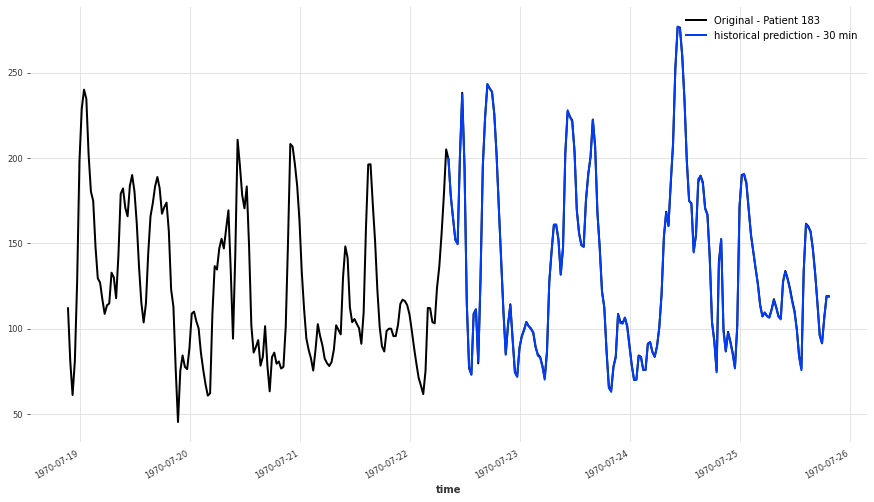

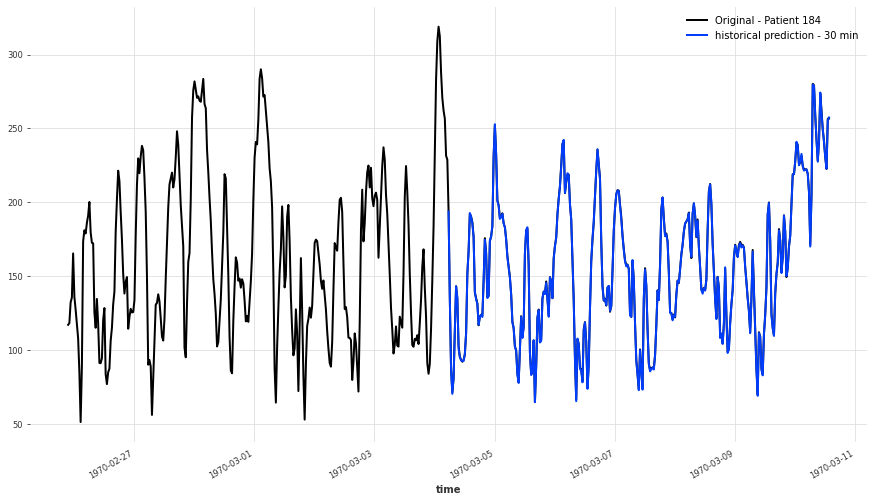

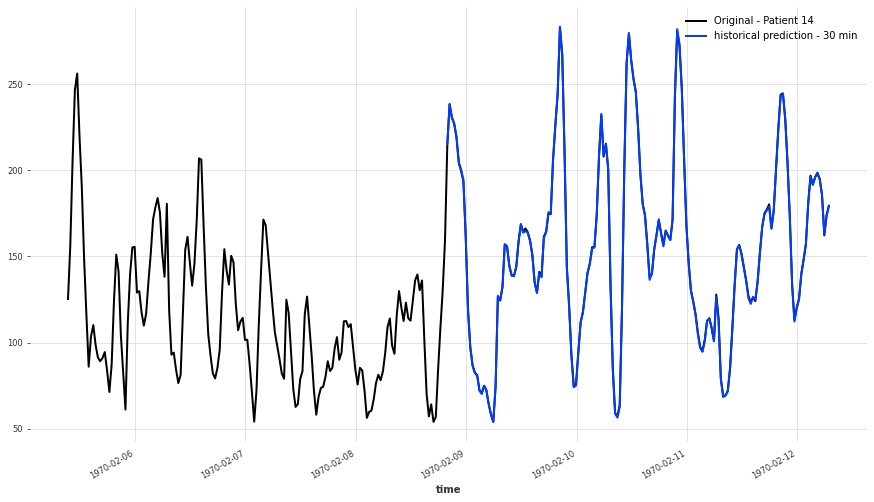

In [ ]:
# Train Historical Prediction plot
index = 0 
for patient_id_index in range(train_cutoff_index, train_cutoff_index+3):
  plt.figure(figsize=(15,8))
  resampled_patient_timeseries_train[patient_id_index].plot(label=f"Train: Original - Patient {patient_ids[patient_id_index]}")
  last_point_historical_predictions_train[patient_id_index].plot(label="Train: historical prediction - 30 min")

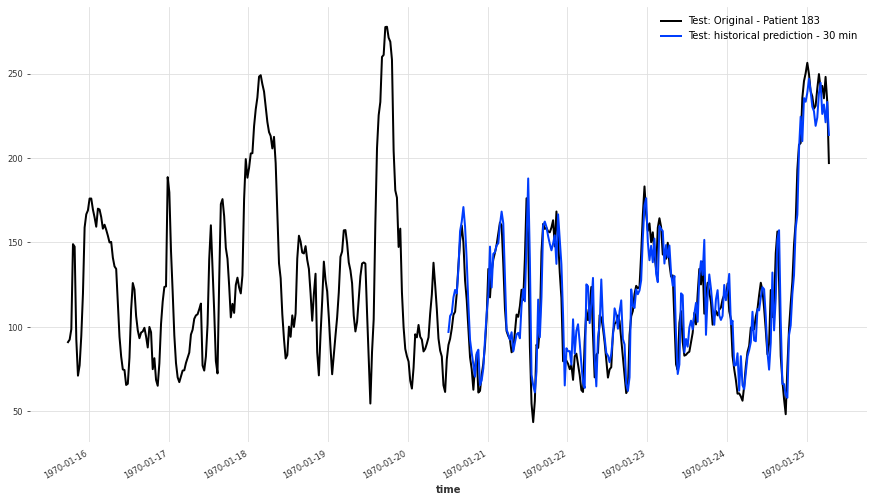

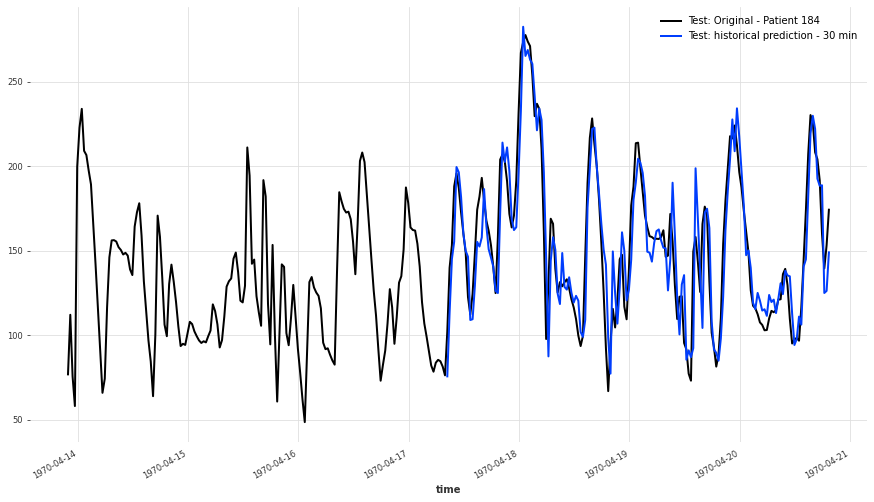

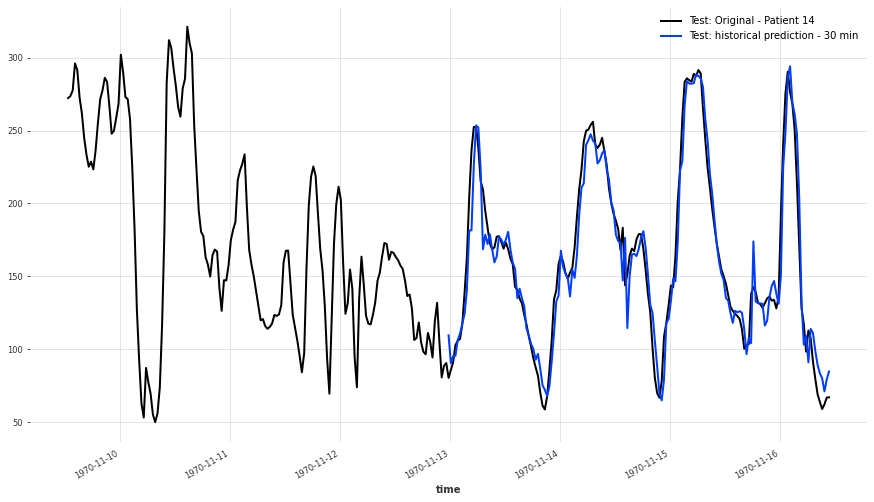

In [ ]:
# Test Historical Prediction plot
index = 0 
for patient_id_index in range(0, 3):
  plt.figure(figsize=(15,8))
  resampled_patient_timeseries_test[patient_id_index].plot(label=f"Test: Original - Patient {patient_ids[patient_id_index]}")
  last_point_historical_predictions_test[patient_id_index].plot(label="Test: historical prediction - 30 min")

Due to the overfitting, and high test MAPE, next steps would be to introduce bias or even dropout if possible or better yet. 

Next step: grid search best number of epochs, number of layers, chunk size, and more with a validation set (`val_series` in a `gridsearch()`) to allow for better validation so we can reduce overfitting by picking the best model hyperparameters in terms of lowest validation MAPE. Basically, pick the hyperparameters which reduce overfitting

see: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.nbeats.html#darts.models.forecasting.nbeats.NBEATSModel.predict.  

In [ ]:
#NBEATS - Parameter Grid Search WIP
# This seems to run very slow OR run out of memory in Google Collab
# TODO: figure out what is causing this to take so long. 
%time
parameters = {
    "n_epochs": [100,200,400],
    "input_chunk_length": [100, 200, 300],
    "output_chunk_length": [1],
    # torch_device_str="cuda" 
    # "num_layers": [200]
}

# last 5000 elements 
nbeats_gridsearch_train_X = resampled_patient_timeseries_train[-50].tail(5000)
nbeats_gridsearch = NBEATSModel.gridsearch(parameters = parameters, 
                        series=nbeats_gridsearch_train_X,
                        forecast_horizon=1,
                        last_points_only=True,
                        metric=mape,
                        # n_jobs=-1,
                        verbose=True
                        )